## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
import sqlite3
import pandas as pd
import gzip as gz
import zipfile
import os
import math
import matplotlib.pyplot as plt

In [2]:
''' # Unused data
with gz.open('zippedData/rt.reviews.tsv.gz') as f:
    rt_reviews = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/rt.movie_info.tsv.gz') as f:
    rt_movie_info = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/tmdb.movies.csv.gz') as f:
    tmdb_movies = pd.read_csv(f)
'''


with gz.open('zippedData/tn.movie_budgets.csv.gz') as f:
    tn_movie_budgets = pd.read_csv(f)
with gz.open('zippedData/bom.movie_gross.csv.gz') as f:
    bom_movie_gross = pd.read_csv(f)
if not os.path.exists('zippedData/im.db'):
    with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
        zipfile.ZipFile.extractall(my_zip,path='zippedData/')
im_db = sqlite3.connect('zippedData/im.db')
im_db_basics = pd.read_sql("""SELECT * FROM movie_basics""",im_db)
im_db_ratings = pd.read_sql("""SELECT * FROM movie_ratings""",im_db)
im_db_persons = pd.read_sql("""SELECT * FROM persons""",im_db)
im_db_principals = pd.read_sql("""SELECT * FROM principals""",im_db)


In [3]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].str[-4:]
tn_movie_budgets['month'] = tn_movie_budgets['release_date'].str[:3]
tn_movie_budgets['clean_budget'] = tn_movie_budgets['production_budget'].str.replace('$','')
tn_movie_budgets['clean_budget'] = tn_movie_budgets['clean_budget'].str.replace(',','').astype(int)
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['domestic_gross'].str.replace('$','')
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['clean_domestic'].str.replace(',','').astype(int)
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['worldwide_gross'].str.replace('$','')
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['clean_worldwide'].str.replace(',','').astype(int)
tn_movie_budgets['clean_foreign'] = tn_movie_budgets['clean_worldwide'] - tn_movie_budgets['clean_domestic']
tn_movie_budgets.rename({'movie':'title'},axis=1,inplace=True)
#tn_movie_budgets.info()
tn_relevant_cols = ['title','year','clean_budget','clean_domestic','clean_foreign','clean_worldwide']
tn_relevant = tn_movie_budgets[tn_relevant_cols]

In [4]:
bom_movie_gross['foreign_gross'] = bom_movie_gross['foreign_gross'].fillna('0')
bom_movie_gross.dropna(inplace=True)
bom_movie_gross['clean_domestic'] = bom_movie_gross['domestic_gross'].astype(int)
bom_movie_gross['clean_foreign'] = bom_movie_gross['foreign_gross'].str.replace(',','').astype(float)
bom_movie_gross['clean_foreign'] = bom_movie_gross['clean_foreign'].apply(math.trunc)
bom_movie_gross['clean_worldwide'] = bom_movie_gross['clean_domestic'] + bom_movie_gross['clean_foreign']
#bom_movie_gross.info()
bom_relevant_cols = ['title','year','clean_domestic','clean_foreign','clean_worldwide']
bom_relevant = bom_movie_gross[bom_relevant_cols]
#bom_relevant.info()

In [5]:
combined_financials = pd.concat([tn_relevant,bom_relevant],ignore_index=True)
combined_financials = combined_financials.drop_duplicates(subset='title',keep='first')
#combined_financials.plot('clean_domestic','clean_foreign',kind='scatter')

#Much of the budget column is empty because bom_movie_gross does not include budget information
#Going to fill the NA budgets with the mean value
combined_financials['clean_budget'].fillna(combined_financials['clean_budget'].median(),inplace=True)
combined_financials['roi_domestic'] = (combined_financials['clean_domestic'] - combined_financials['clean_budget']) / combined_financials['clean_budget']
combined_financials['roi_worldwide'] = (combined_financials['clean_worldwide'] - combined_financials['clean_budget']) / combined_financials['clean_budget']

In [92]:
im_db_combined = im_db_basics.merge(im_db_ratings,on='movie_id',how='inner')
im_db_combined = im_db_combined.drop_duplicates(subset = 'primary_title', keep='first')
im_db_combined.rename({'primary_title':'title'},axis=1,inplace=True)
im_db_with_financial = im_db_combined.merge(combined_financials,on = 'title',how = 'inner')
im_db_with_financial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3550 entries, 0 to 3549
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         3550 non-null   object 
 1   title            3550 non-null   object 
 2   original_title   3550 non-null   object 
 3   start_year       3550 non-null   int64  
 4   runtime_minutes  3491 non-null   float64
 5   genres           3548 non-null   object 
 6   averagerating    3550 non-null   float64
 7   numvotes         3550 non-null   int64  
 8   year             3550 non-null   object 
 9   clean_budget     3550 non-null   float64
 10  clean_domestic   3550 non-null   int64  
 11  clean_foreign    3550 non-null   int64  
 12  clean_worldwide  3550 non-null   int64  
 13  roi_domestic     3550 non-null   float64
 14  roi_worldwide    3550 non-null   float64
dtypes: float64(5), int64(5), object(5)
memory usage: 443.8+ KB


In [61]:
genre_set = set()
genre_df = im_db_with_financial['genres'].dropna()
for genres in genre_df.values:
    genre_list = genres.split(',')
    new_genre_set = set(genre_list)
    genre_set = genre_set.union(new_genre_set)
#genre_set

In [84]:
genre_plot_roi = []
genre_comparison_df = pd.DataFrame
for genre in genre_set:
    roi_series = im_db_with_financial[im_db_with_financial['genres'].str.contains(genre) == True]['roi_worldwide']
    roi_series.rename(genre,inplace=True)
    genre_plot_roi.append(roi_series)


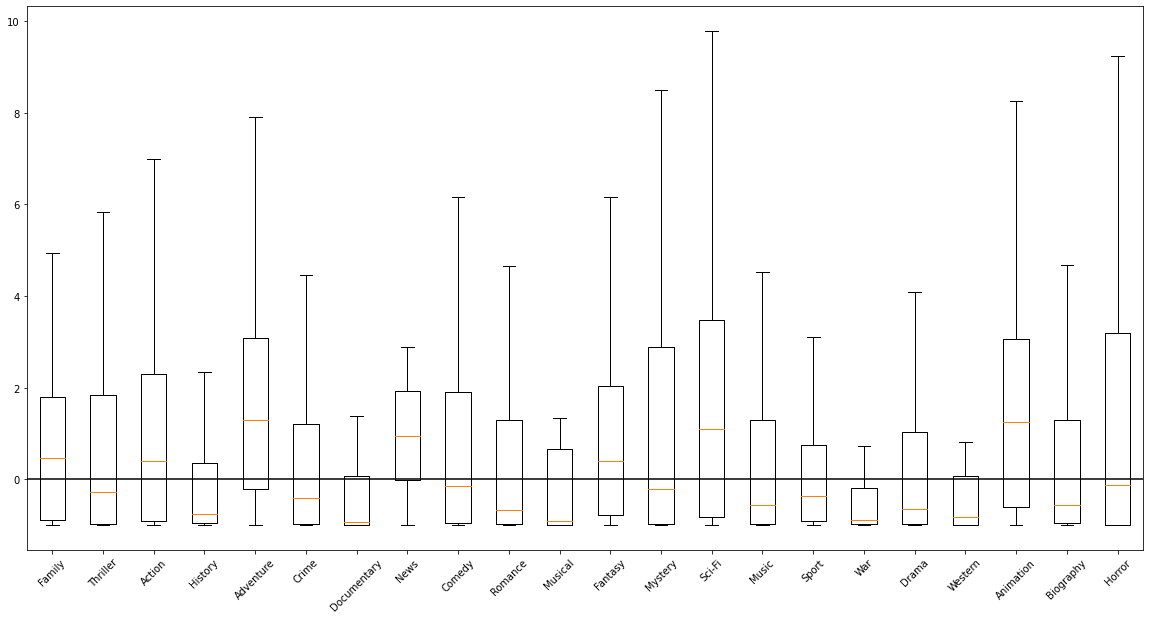

In [87]:
fig,ax = plt.subplots(figsize = (20,10))
ax.boxplot(genre_plot_roi,labels = [series.name for series in genre_plot_roi],showfliers=False);
ax.tick_params(axis='x',labelrotation=45)
ax.axhline(y=0, color='k');